- Use Black-Litterman model to get a posterior estimation of stocks' return

- Use sentiment score from alphavantage as views

- predict 10 days posterior expected returns with sentiment socre, make an array to store the date with the expected return then make portfolio optimization, compare the culmulative return (compare which with which?) dynamic adjust results with steady weight results?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["AAPL", "AMZN", "META", "NFLX", "NVDA", "TSLA"]
# tickers = ['AAPL', 'AMZN', 'COST', 'DIS', 'GOOGL', 'JPM', 'LLY',  'MSFT','META', 'NFLX', 'NVDA', 'TSLA']
start_date = "2024-07-01"
end_date = '2024-07-31'
ohlc = yf.download(tickers, start = start_date, end=end_date)
# ohlc = yf.download(tickers, period="max") 
prices = ohlc["Adj Close"]

# SPY: SPDR S&P 500 ETF Trust. It is designed to track the S&P 500 stock market index. This fund is the largest and oldest ETF in the USA.
market_prices = yf.download("SPY", start = start_date, end=end_date)["Adj Close"]
# market_prices = yf.download("SPY", period="max")["Adj Close"]

# market_prices.head()

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


In [16]:
prices.tail()

Ticker,AAPL,AMZN,META,NFLX,NVDA,TSLA
Date,,,,,,
2024-07-24,218.287323,180.830002,461.269989,635.989990,114.250000,215.990005
2024-07-25,217.238556,179.850006,453.410004,634.090027,112.279999,220.250000
2024-07-26,217.708008,182.500000,465.700012,631.369995,113.059998,219.800003
2024-07-29,217.987686,183.199997,465.709991,626.960022,111.589996,232.100006
2024-07-30,218.547043,181.710007,463.190002,622.580017,103.730003,222.619995


<Axes: xlabel='Date'>

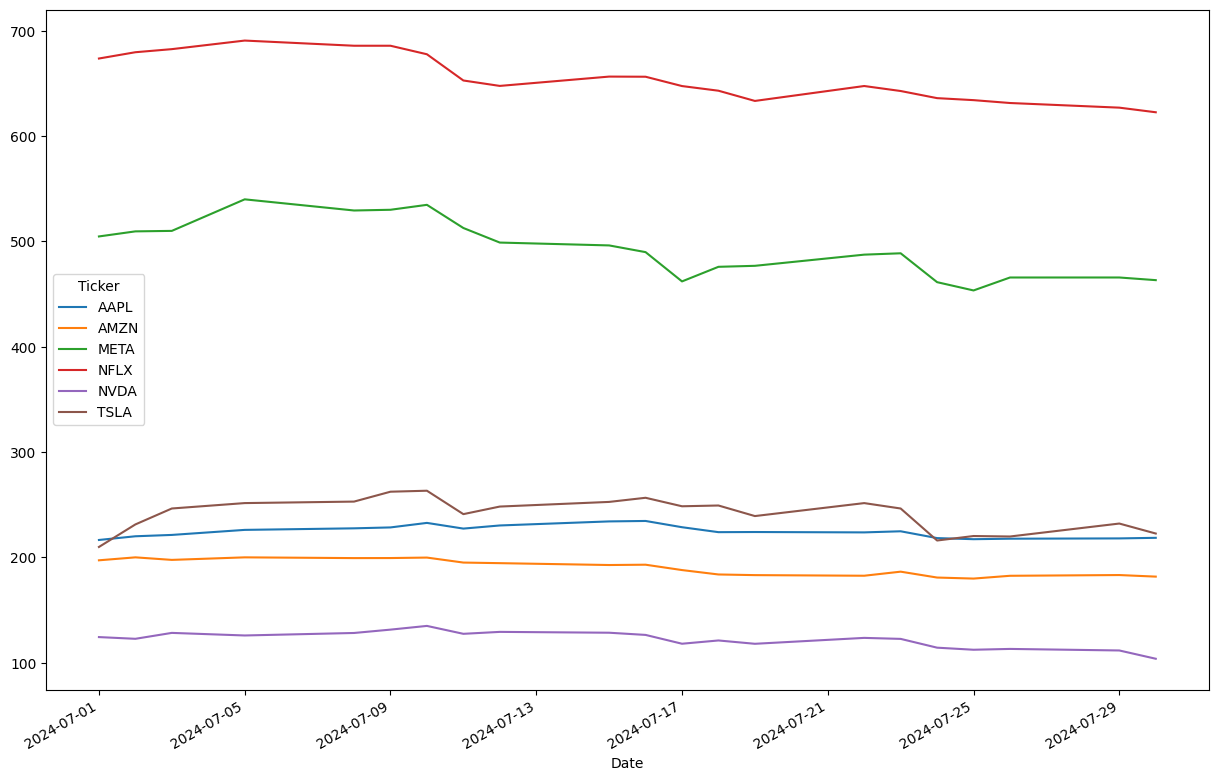

In [17]:
prices.plot(figsize=(15,10))

# Calculate the market implied prior returns

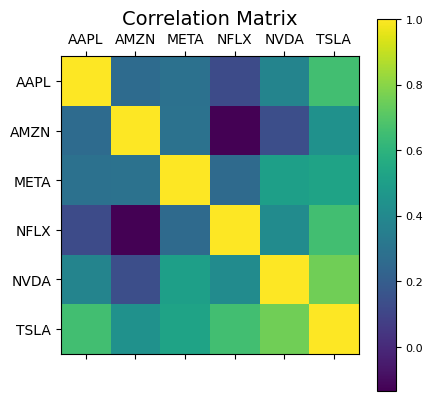

In [3]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel

mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf() # Covariance Matrix of asset returns

# Plot correlation matrix
plt.matshow(S.corr())
plt.xticks(range(S.select_dtypes(['number']).shape[1]), S.select_dtypes(['number']).columns, fontsize=10)
plt.yticks(range(S.select_dtypes(['number']).shape[1]), S.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=14)

delta = black_litterman.market_implied_risk_aversion(market_prices) # Prior estimate of returns, calculated by the market’s excess return divided by its variance: (R-R_f)/sig^2
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# Use sentiment score from alphavantage to calculate the veiws
Use sentiment score gamma to calculate new stock price

  $$ S_T=   \left\{
\begin{array}{ll}
      S_0+[(S_{MC}^+ -S_0) \cdot \gamma] & \text{ if }  \gamma \text{ in } (0, 1] \\
      S_0-[(S_0 - S_{MC}^-) \cdot  \gamma] & \text{ if } \gamma \text{ in } [-1, 0) \\
\end{array} 
\right.  $$
We need to use Monte Carlo to simulate possible stock prices to get $S_{MC}^-$ and $S_{MC}^+$.

Then 
$$Views= \ln (\frac{S_T}{S_0})$$

In [4]:
days = 10  # Number of trading days
def get_data(ticker):
    df_news = pd.read_csv(f'../data/{ticker}_news_data.csv', index_col='date',parse_dates=True,dtype=float)
    return df_news
# use the average of sentiment score from the last 10 days 
sentiment = {}
confidences = []
for ticker in tickers:
    sentiment[ticker] = get_data(ticker)['sentiment_score'][-days:].mean()
    confidences.append(get_data(ticker)['relevance_score'][-days:].mean())

In [5]:
sentiment

{'AAPL': 0.1988586986781054,
 'AMZN': 0.2036053745559495,
 'META': 0.08277459231498044,
 'NFLX': 0.21196993102999953,
 'NVDA': 0.20442631459042632,
 'TSLA': 0.16068605371521524}

## Monte Carlo simulation for stock prices

In [6]:
# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Estimate parameters
mean_return = log_returns.mean()
volatility = log_returns.std()

# Monte Carlo simulation parameters
num_simulations = 1000
num_days = days  # Number of trading days

# Step 4: Simulate future prices
def monte_carlo_simulation(start_price, mean_return, volatility, num_days, num_simulations):
    simulated_prices = np.zeros((num_days, num_simulations))
    simulated_prices[0] = start_price

    for t in range(1, num_days):
        random_shocks = np.random.normal(loc=mean_return, scale=volatility, size=num_simulations)
        simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_shocks)
    
    return simulated_prices

def NewStockPrice(gamma, S, S0):
    if gamma <0:
        S_T= S0 - (S0 - S.min())*gamma
    else:
        S_T= S0 + (S.max() - S0)*gamma
    return S_T


## calculate the views

In [7]:
viewdict = {}
for ticker in tickers:
    start_price = prices[ticker].iloc[-1]
    simulated_prices = monte_carlo_simulation(start_price, mean_return[ticker], volatility[ticker], num_days, num_simulations)
    ST = NewStockPrice(sentiment[ticker], simulated_prices, start_price)
    viewdict[ticker] = (ST-start_price)/ST
    # viewdict[ticker] = np.log(ST/start_price)


In [8]:
viewdict

{'AAPL': 0.019475474486176956,
 'AMZN': 0.017215594397288196,
 'META': 0.015377238890140374,
 'NFLX': 0.012295258719195422,
 'NVDA': 0.04348323737687791,
 'TSLA': 0.06371089022649866}

In [9]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

Posterior Estimates 

In [10]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,-0.245230,-0.117053,0.019475
AMZN,-0.183691,-0.081570,0.017216
META,-0.382524,-0.214644,0.015377
NFLX,-0.128560,-0.049360,0.012295
NVDA,-0.598971,-0.349291,0.043483
TSLA,-0.753029,-0.370731,0.063711


<Axes: >

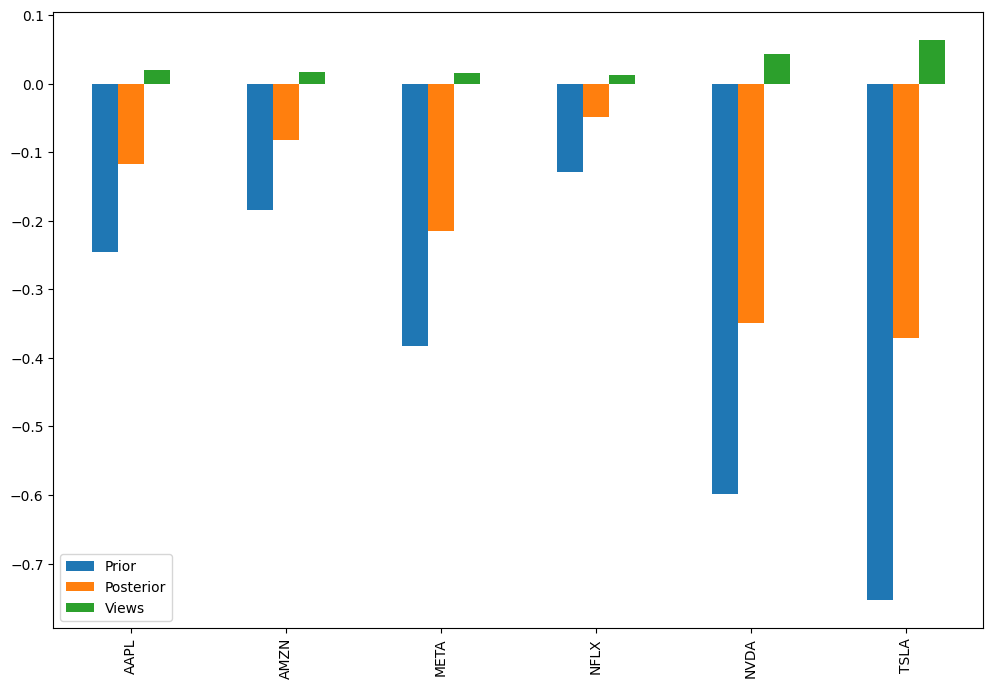

In [11]:
rets_df.plot.bar(figsize=(12,8))

# Portfolio optimization by mean-variance 

In [15]:
from pypfopt import EfficientFrontier, objective_functions
# Optimize for maximal Sharpe ratio
# Long/short: by default all of the mean-variance optimization methods in PyPortfolioOpt are long-only, but they can be initialised to allow for short positions by changing the weight bounds:ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
# The risk-free rate of return is the theoretical rate of return that an investor would expect on an investment with zero risk.
S_bl = bl.bl_cov()
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe(risk_free_rate=-0.5)
# ef.max_sharpe(risk_free_rate=-0.5)
weights = ef.clean_weights()
weights

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.24148),
             ('AMZN', 0.26944),
             ('META', 0.14267),
             ('NFLX', 0.29754),
             ('NVDA', 0.04886),
             ('TSLA', 0.0)])

In [ ]:
# compare the results 